The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Average Feature Importance Across Patients:
------------------------------------------
time                :  18.49% ±  4.45%
glucose             :  16.67% ±  2.40%
glucose_change      :  10.68% ±  1.61%
glucose_change_projected:  10.05% ±  2.06%
glucose_projected   :   9.76% ±  1.62%
dietary_fibers      :   9.73% ±  2.99%
proteins            :   8.30% ±  4.50%
fats                :   6.86% ±  4.56%
complex_sugars      :   5.62% ±  3.04%
simple_sugars       :   3.40% ±  3.75%
insulin             :   0.43% ±  0.53%

Feature Importance for Patient 001:
------------------------------------------
glucose             :  13.92%
time                :  11.81%
glucose_change      :  11.25%
dietary_fibers      :  10.27%
proteins            :  10.13%
complex_sugars      :   8.72%
simple_sugars       :   8.58%
glucose_change_projected:   8.30%
fats                :   8.30%
glucose_projected   :   8.02%
insulin             :   0.70%

Feature Importance for Patient 002:
----------------------------

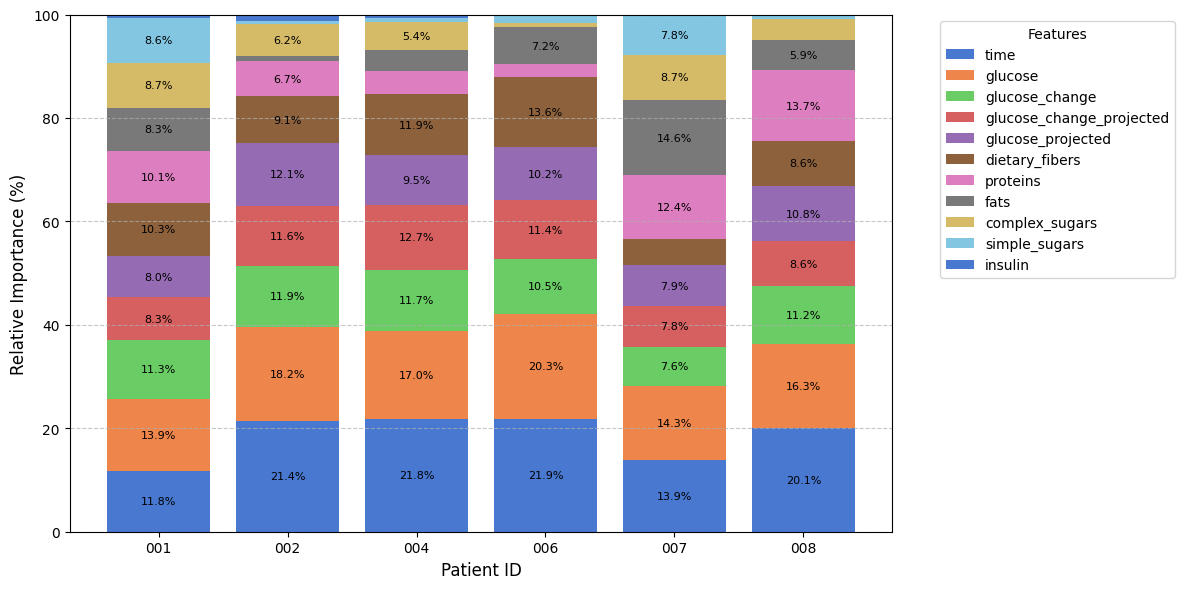

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Constants
patients = ['001', '002', '004', '006', '007', '008']
model_path = 'models/pixtral-large-latest/12'

def load_and_process_importances():
    # Load models and extract importances
    feature_importances = {}
    for patient in patients:
        model_file = Path(model_path) / f'patient_{patient}_model.pkl'
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
            # Convert to relative importance (sums to 100%)
            importances = model.feature_importances_
            relative_importances = (importances / importances.sum()) * 100
            feature_importances[patient] = dict(zip(model.feature_name_, relative_importances))
    
    return pd.DataFrame(feature_importances)

def plot_relative_importances(df):
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Use seaborn color palette
    n_features = len(df.index)
    colors = sns.color_palette("muted", n_features)
    
    # Create stacked bar plot
    bottom = np.zeros(len(df.columns))
    
    for idx, feature in enumerate(df.index):
        values = df.loc[feature]
        ax.bar(df.columns, values, bottom=bottom, label=feature, color=colors[idx])
        bottom += values
    
    # Customize plot
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Relative Importance (%)', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=0)
    
    # Add legend with smaller font and outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=10, title='Features')
    
    # Add percentage labels inside bars
    for i in range(len(df.columns)):
        bottom = 0
        for j in range(len(df.index)):
            value = df.iloc[j, i]
            if value >= 5:  # Only show labels for features with >5% importance
                plt.text(i, bottom + value/2, f'{value:.1f}%', 
                        ha='center', va='center', fontsize=8)
            bottom += value
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to show percentages
    ax.set_ylim(0, 100)
    
    return fig

# Get feature importances
importances_df = load_and_process_importances()

# Sort features by average importance
avg_importance = importances_df.mean(axis=1)
importances_df = importances_df.reindex(avg_importance.sort_values(ascending=False).index)

# Create and show plot
fig = plot_relative_importances(importances_df)

# Print summary statistics
print("\nAverage Feature Importance Across Patients:")
print("------------------------------------------")
mean_importance = importances_df.mean(axis=1)
std_importance = importances_df.std(axis=1)
for feature in mean_importance.index:
    print(f"{feature:20s}: {mean_importance[feature]:6.2f}% ± {std_importance[feature]:5.2f}%")

# Print feature importances for each patient
for patient in patients:
    print(f"\nFeature Importance for Patient {patient}:")
    print("------------------------------------------")
    patient_importances = importances_df[patient].sort_values(ascending=False)
    for feature, importance in patient_importances.items():
        print(f"{feature:20s}: {importance:6.2f}%")

plt.savefig('images/feature_importances.eps', dpi=300)
plt.show()